In [12]:
import sqlite3
import json
import pandas as pd
DB_PATH = 'data/experiments.db'

In [26]:
def get_experiments_details(experiment_ids):
    with sqlite3.connect(db_path) as conn:
        # Convert list of experiment_ids to a string format suitable for the SQL query
        formatted_ids = ','.join(map(str, experiment_ids))

        # SQL query to get the desired information
        query = f"""
        SELECT 
            E.experiment_id, 
            E.start_time, 
            E.config_id, 
            json_extract(EC.agent_config, '$.agent_id') AS agent_id,
            json_extract(EC.agent_config, '$.matrices_mode') AS matrices_mode,
            json_extract(EC.gridlink_config, '$.grid_shape') AS grid_shape,
            json_extract(EC.gridlink_config, '$.n_predictable_cycles') AS n_predictable_cycles,
            json_extract(EC.gridlink_config, '$.n_unpredictable_cycles') AS n_unpredictable_cycles,
            json_extract(EC.agent_config, '$.n_obs') AS n_obs,
            json_extract(EC.agent_config, '$.n_states') AS n_states,
            (SELECT COUNT(*) FROM Steps WHERE Steps.experiment_id = E.experiment_id) AS steps_count
        FROM Experiment AS E
        JOIN ExperimentConfig AS EC ON E.config_id = EC.config_id
        WHERE E.experiment_id IN ({formatted_ids})
        """

        # Execute the query and fetch results directly into a pandas DataFrame
        df = pd.read_sql_query(query, conn)

    # Return the DataFrame
    return df

def prepare_experiment_data(experiment_id):
    with sqlite3.connect(DB_PATH) as conn:
        # Query to get the steps for the given experiment_id
        query = f"""
        SELECT 
            step_num, 
            agent_action, 
            environment_state
        FROM Steps
        WHERE experiment_id = {experiment_id}
        ORDER BY step_num
        """

        # Execute the query and fetch results directly into a pandas DataFrame
        df = pd.read_sql_query(query, conn)


        # Deserialize the agent_action binary data and map it to 0 or 1
        df['agent_action'] = df['agent_action'].apply(lambda x: 1 if x == b'\x00\x00\x00\x00\x00\x00\xf0?' else 0)

        # Parse the environment_state JSON string and create new columns
        df['status'] = df['environment_state'].apply(lambda x: json.loads(x)['status'])
        df['score'] = df['environment_state'].apply(lambda x: json.loads(x)['rally'])
        df['ball_y'] = df['environment_state'].apply(lambda x: json.loads(x)['ball_y'])
        df['paddle_y'] = df['environment_state'].apply(lambda x: json.loads(x)['paddle_y'])

        # Calculate the ball_paddle_alignment
        df['ball_paddle_alignment'] = df['paddle_y'] - df['ball_y']

        # Drop the original environment_state column
        df.drop('environment_state', axis=1, inplace=True)
        df.drop(['ball_y','paddle_y'], axis=1, inplace=True)
        # df.drop(['paddle_y','ball_y'],inplace=True)

    # Return the DataFrame with the new structure
    return df

In [11]:
experiment_ids = list(range(210,226))
get_experiments_details(experiment_ids)

,experiment_id,start_time,config_id,agent_id,matrices_mode,grid_shape,n_predictable_cycles,n_unpredictable_cycles,n_obs,n_states,steps_count
0,210,2023-11-07 00:52:30,85,None,uniform,"[2,3]",1,4,8,8,300
1,211,2023-11-07 00:52:52,85,None,uniform,"[2,3]",1,4,8,8,1037
2,212,2023-11-07 00:53:34,86,None,random,"[2,3]",4,800,8,8,66
3,213,2023-11-07 00:53:46,87,None,random,"[2,3]",4,800,8,8,654
4,214,2023-11-07 01:03:41,87,None,random,"[2,3]",4,800,8,8,157
5,215,2023-11-07 01:03:47,87,None,random,"[2,3]",4,800,8,8,559
6,216,2023-11-07 01:04:12,87,None,random,"[2,3]",4,800,8,8,244
7,217,2023-11-07 01:04:35,88,None,random,"[2,3]",4,800,8,8,3535
8,218,2023-11-07 01:07:05,89,None,random,"[2,3]",4,800,8,8,50000
9,219,2023-11-07 08:52:06,89,None,random,"[2,3]",4,800,8,8,50000


In [27]:
ex_255 = prepare_experiment_data(225)

In [33]:
def calculate_metrics(df):
    # Calculate hits and misses
    df['hits'] = (df['status'] == 1).cumsum()
    df['misses'] = (df['status'] == -1).cumsum()

    # Avoid division by zero for hit_miss_ratio
    df['hit_miss_ratio'] = df['hits'] / df['misses'].replace({0: 1})

    # Calculate long rallies
    df['long_rallies'] = (df['score'] >= 3).cumsum()

    # Calculate aces
    df['aces'] = ((df['status'] == -1) & (df['score'].shift(1) == 0)).cumsum()

    return df[['step_num', 'hits', 'misses', 'hit_miss_ratio', 'long_rallies', 'aces']]
calculate_metrics(ex_255)

,step_num,hits,misses,hit_miss_ratio,long_rallies,aces
0,1,0,0,0.00,0,0
1,2,0,0,0.00,0,0
2,3,0,0,0.00,0,0
3,4,0,0,0.00,0,0
4,5,0,0,0.00,0,0
...,...,...,...,...,...,...
639,640,2,8,0.25,0,6
640,641,2,8,0.25,0,6
641,642,2,8,0.25,0,6
642,643,2,8,0.25,0,6


<Axes: >

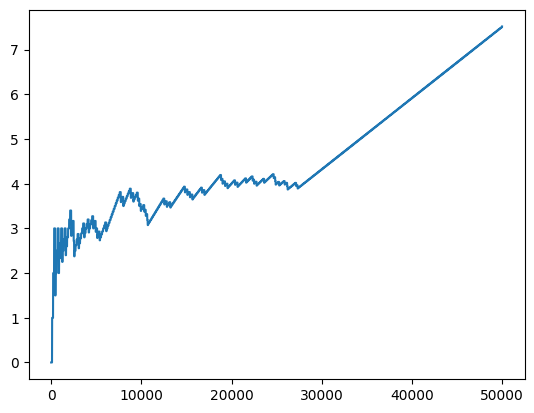

In [42]:
ex = calculate_metrics(prepare_experiment_data('219'))
ex.hit_miss_ratio.plot()

<Axes: >

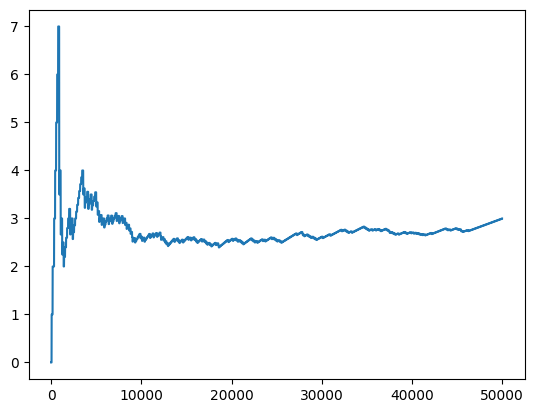

In [43]:
ex218 = calculate_metrics(prepare_experiment_data('218'))
ex218.hit_miss_ratio.plot()

<Axes: >

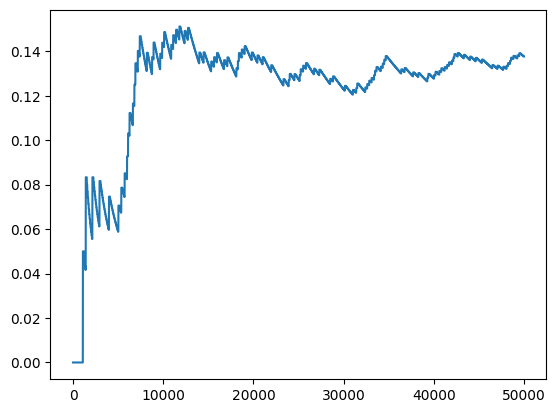

In [41]:
#Control
ex222 = calculate_metrics(prepare_experiment_data('222'))
ex222.hit_miss_ratio.plot()

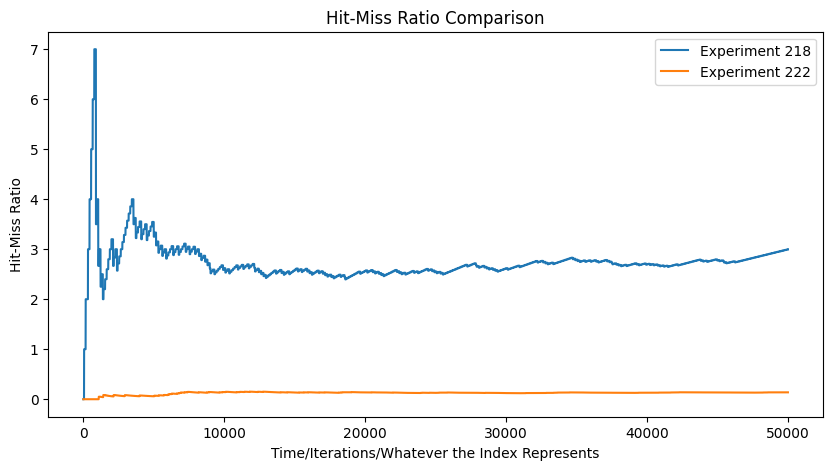

In [44]:
import matplotlib.pyplot as plt

# Assuming calculate_metrics returns a DataFrame with a 'hit_miss_ratio' column.

# Prepare the data
ex218_data = prepare_experiment_data('218')
ex218_metrics = calculate_metrics(ex218_data)


ex222_data = prepare_experiment_data('222')
ex222_metrics = calculate_metrics(ex222_data)

# Create a plot
plt.figure(figsize=(10, 5))  # You can adjust the figure size to your liking

# Plot each experiment's hit_miss_ratio on the same Axes
plt.plot(ex218_metrics.index, ex218_metrics.hit_miss_ratio, label='Experiment 218')
plt.plot(ex222_metrics.index, ex222_metrics.hit_miss_ratio, label='Experiment 222')

# Add some useful labels and title
plt.xlabel('Time/Iterations/Whatever the Index Represents')
plt.ylabel('Hit-Miss Ratio')
plt.title('Hit-Miss Ratio Comparison')

# Add a legend to distinguish the two lines
plt.legend()

# Show the plot
plt.show()


<Axes: xlabel='step_num', ylabel='hit_miss_ratio'>

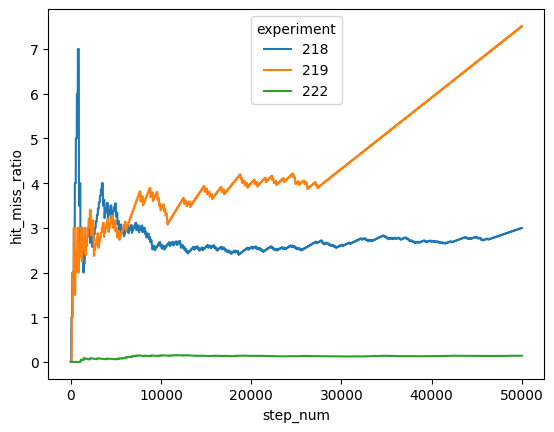

In [52]:
import seaborn as sns
import pandas as pd

# Reset the index so 'step_num' becomes a column
ex218_metrics = ex218_metrics
ex219_metrics = calculate_metrics(prepare_experiment_data('219'))
ex222_metrics = ex222_metrics

# Add an 'experiment' column to distinguish between the two datasets
ex218_metrics['experiment'] = '218'
ex219_metrics['experiment'] = '219'
ex222_metrics['experiment'] = '222'

# Concatenate the two DataFrames into one
combined_metrics = pd.concat([ex218_metrics,ex219_metrics,ex222_metrics])

# Now plot using seaborn
sns.lineplot(data=combined_metrics, x='step_num', y='hit_miss_ratio', hue='experiment')
